### Predicting recurrence of thyroid cancer - Part 2 | Machine Learning





<span style=font-size:14px>
We have already conducted exploratory data analysis and classical logistical regression in part 1. We now proceed with machine learning models.

#### 1. Importing libraries and data

In [2]:
# =========================
# Core libraries
# =========================
import warnings

import numpy as np
import pandas as pd

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import plotly.express as px

# =========================
# Statistics & Modeling
# =========================
import statsmodels.formula.api as smf

# =========================
# Machine Learning (scikit-learn)
# =========================

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Calibration
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve, brier_score_loss
)

# =========================
# Other analytical tools
# =========================
from tableone import TableOne

# =========================
# Import UCI ML repository
# =========================

from ucimlrepo import fetch_ucirepo 

# =========================
# Suppress warnings
# =========================
warnings.filterwarnings("ignore")

# =========================
# Importing data from the UCI repository
# =========================

# fetch dataset 
differentiated_thyroid_cancer_recurrence = fetch_ucirepo(id=915) 
# data (as pandas dataframes) 
X = differentiated_thyroid_cancer_recurrence.data.features 
y = differentiated_thyroid_cancer_recurrence.data.targets 
  
# metadata 
# print(differentiated_thyroid_cancer_recurrence.metadata) 
# variable information 
# print(differentiated_thyroid_cancer_recurrence.variables) 
# combine X and y into a single dataframe
tcr_ml = pd.concat([X, y], axis=1)

#### 2. Machine learning classification algorithms

<span style=font-size:14px>
In machine learning, we are more interested in making predictions on new data. As for classical logistic regression, we need to define the problem, with in this case, is a classification problem. We need to assess how well a model, givent the set of predictors, can predict recurrence in a new patient. This requires us to split the data into a training set and a test set. The training set will be used to train the model, and the test set will be used to evaluate the model's performance on unseen data. We will use various classification algorithms to build models that can predict recurrence based on the predictors in the dataset. We will evaluate the models using metrics such as accuracy, precision, recall, F1-score, and ROC-AUC.

<span style=font-size:14px>
In this exercise, we applied several machine learning algorithms to publicly available data on thyroid cancer recurrence to evaluate their predictive performance. Our findings show that, after removing highly correlated variables, logistic regression achieved the strongest overall results, outperforming more complex models. This outcome underscores the sensitivity of logistic regression to multicollinearity and demonstrates how careful feature selection can enhance its predictive power beyond that of other algorithms.

In [13]:
# Separate features & target
X = tcr_ml.drop(columns=["Recurred"])  # adjust target column name if different
# Map 'No' to 0 and 'Yes' to 1
y = tcr_ml["Recurred"].map({"No": 0, "Yes": 1}).astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# One-hot encode categorical + scale numeric
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), X.select_dtypes(include="object").columns),
    ("num", StandardScaler(), X.select_dtypes(include=np.number).columns)
])


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.4057 - auc: 0.5281 - loss: 0.7500 - precision: 0.2928 - recall: 0.7571 - val_accuracy: 0.6129 - val_auc: 0.5985 - val_loss: 0.6762 - val_precision: 0.3000 - val_recall: 0.3750
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7049 - auc: 0.6074 - loss: 0.6422 - precision: 0.4839 - recall: 0.4286 - val_accuracy: 0.7742 - val_auc: 0.7534 - val_loss: 0.5824 - val_precision: 0.6250 - val_recall: 0.3125
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7951 - auc: 0.7933 - loss: 0.5477 - precision: 0.8333 - recall: 0.3571 - val_accuracy: 0.7742 - val_auc: 0.8424 - val_loss: 0.5145 - val_precision: 0.6667 - val_recall: 0.2500
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8033 - auc: 0.8475 - loss: 0.4927 - precision: 0.8667 - recall: 0.3714 - val_accuracy: 0.7903 - val_auc: 0.8832 - val_loss: 0.4650 - val_precision: 0.8000 - val_recall: 0.2500
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/

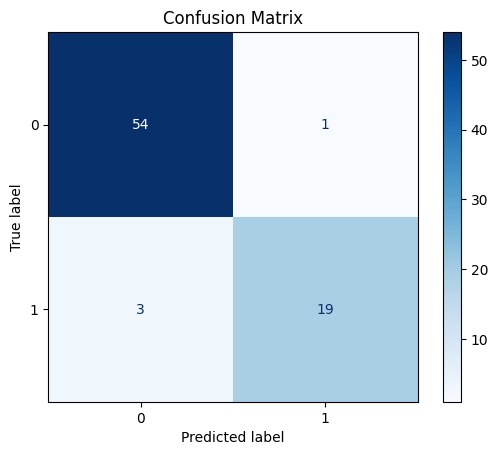

Sensitivity (Recall): 0.864
Specificity: 0.982
PPV (Precision): 0.950
NPV: 0.947


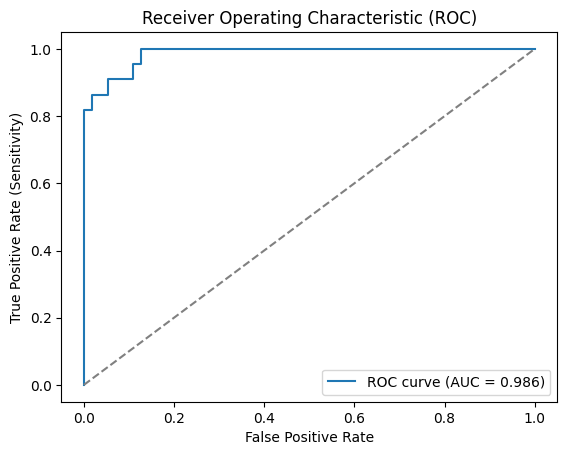

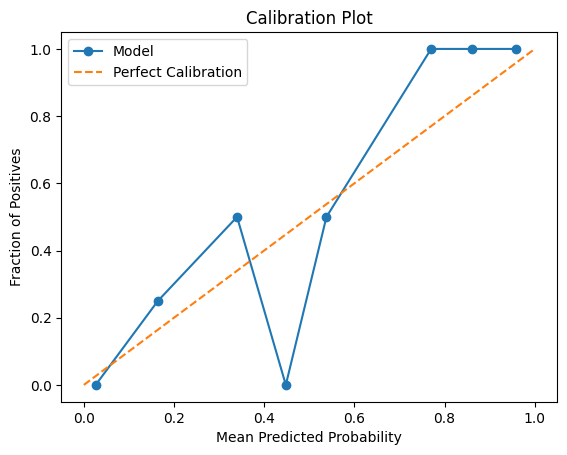

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.calibration import calibration_curve

# =============================
# Preprocessing
# =============================
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), X.select_dtypes(include="object").columns),
    ("num", StandardScaler(), X.select_dtypes(include=np.number).columns)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# =============================
# Build Keras model
# =============================
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_proc.shape[1],)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam", 
    loss="binary_crossentropy", 
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

# =============================
# Training
# =============================
history = model.fit(
    X_train_proc, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

# =============================
# Evaluation
# =============================
loss, acc, auc_score, precision, recall = model.evaluate(X_test_proc, y_test, verbose=0)
print(f"Test Accuracy: {acc:.3f}, ROC AUC: {auc_score:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

# =============================
# Predictions
# =============================
y_pred_prob = model.predict(X_test_proc).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

# =============================
# Confusion Matrix
# =============================
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)   # Recall
specificity = tn / (tn + fp)
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"PPV (Precision): {ppv:.3f}")
print(f"NPV: {npv:.3f}")

# =============================
# ROC Curve
# =============================
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.show()

# =============================
# Calibration Plot
# =============================
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0,1], [0,1], linestyle="--", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Plot")
plt.legend()
plt.show()


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), X.select_dtypes(include="object").columns),
    ("num", StandardScaler(), X.select_dtypes(include=np.number).columns)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_proc.toarray() if hasattr(X_train_proc, "toarray") else X_train_proc, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor  = torch.tensor(X_test_proc.toarray() if hasattr(X_test_proc, "toarray") else X_test_proc, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Dataset + Dataloader
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

# Define model
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

model = Net(X_train_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(20):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Evaluation
with torch.no_grad():
    preds = (model(X_test_tensor) > 0.5).float()
    acc = (preds.eq(y_test_tensor).sum() / y_test_tensor.shape[0]).item()
print(f"Test Accuracy: {acc:.3f}")


Epoch 5, Loss: 0.4487
Epoch 10, Loss: 0.2055
Epoch 15, Loss: 0.2569
Epoch 20, Loss: 0.2723
Test Accuracy: 0.987


Resources
</span>

<span style=font-size:14px>
Finally I would like to provide some resources that I found useful in this project and would benefit both the beginner and the experienced data scientist as a refresher.

- Statquest by Josh Starmer: https://www.youtube.com/@statquest. Josh has the gift of breaking down complex and esoteric concepts into bite-sized pieces digestible by the layman. You can also support him by purchasing his books "The StatQuest Illustrated Guide to MachineLearning!!!".
- The Python Data Science Handbook by Jake VanderPlas, available free online at https://jakevdp.github.io/PythonDataScienceHandbook/. This is a comprehensive guide to the Python data science ecosystem, including NumPy, Pandas, Matplotlib, Scikit-Learn, and more. However, it may need a little bit of background knowledge on python programming for eas of understanding.
- The scikit-learn official website https://scikit-learn.org/stable/index.html

<span style="font-size:14px">

*Thanks for reading me!*
</span>
